In [1]:
from dataloaders import gather_static_graphs
import dgl
from dgl.data import DGLDataset
import torch
import os
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np

/home/ding/anaconda3/envs/comp579/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch.nn as nn
from dgl.nn import GraphConv # GCN
import torch.nn.functional as F
from sklearn import metrics
import torch.nn as nn
import torch.optim
# from pytorch_lightning import LightningModule
from torch.nn import Sequential, Linear, Sigmoid
from torch.nn import functional as F
from torch_scatter import scatter_add
from torch.nn import ReLU

from torch_geometric.nn import GCNConv

In [9]:
data_file = 'LA_DATA_2018_02_to_2018_06.csv'
# node_cols = 'visibility', 'precipitation_depth']
node_cols = ['wind_x', 'wind_y', 'temperature', 'pressure', 'ceiling', 'dew', 'precipitation_duration' , 'mean_aod','min_aod','max_aod', 'pm25']                                                 
edge_cols = ['wind_x', 'wind_y']
dist_thresh = 30e6
use_self_loops = True
multi_edge_feature = False

graph_states_loader, graph =  gather_static_graphs(data_file,
                                                    edge_cols,
                                                    node_cols, 
                                                    dist_thresh,
                                                    multi_edge_feature,
                                                    use_self_loops)


Checkpt doesnt exist, making it


In [10]:
for i, (nf, ef, l) in enumerate(graph_states_loader): 
    if i ==1: 
        labels = l
    if i ==1: 
        node_features = nf
        edge_features = ef
    

In [11]:
class MaskedGraphDataset(DGLDataset):
    def __init__(self, 
                node_features,
                edge_features,
                labels, 
                graph, 
                train_test_split = 0.9):

        self.node_features = node_features.squeeze()
        self.edge_features = edge_features.squeeze()
        self.labels = labels.squeeze()
        self.edge_src, self.edge_dst = graph.edge_index
        self.train_test_split = train_test_split
        super().__init__(name = 'MaskedPollutionGraph')

    def process(self):

        self.edge_src = torch.tensor(self.edge_src)
        self.edge_dst = torch.tensor(self.edge_dst)

        n_nodes = self.node_features.shape[0]

        self.graph = dgl.graph((self.edge_src, self.edge_dst), num_nodes=n_nodes)
        self.graph.ndata['feat'] = self.node_features.float()
        self.graph.ndata['label'] = self.labels.float()
        self.graph.edata['weight'] = self.edge_features.float()

        n_train = int(n_nodes * self.train_test_split)
        n_val = n_nodes - n_train
        train_mask = torch.zeros(n_nodes, dtype=torch.bool)
        val_mask = torch.zeros(n_nodes, dtype=torch.bool)

        train_mask[:n_train] = True
        val_mask[n_train:] = True

        self.graph.ndata['train_mask'] = train_mask
        self.graph.ndata['val_mask'] = val_mask

        mask = self.graph.ndata['train_mask']
        masked_idx = torch.argwhere(~mask).flatten()
        training_masked_dst = self.edge_src[self.edge_src != masked_idx]
        training_masked_src = self.edge_dst[self.edge_dst != masked_idx]
        self.edge_index = torch.LongTensor(torch.stack([self.edge_src, self.edge_dst]))
        self.training_masked_edge_index = torch.LongTensor(torch.stack([training_masked_src, training_masked_dst]))

    def __getitem__(self, i):
        return self.graph

    def __len__(self):
        return 1

In [12]:
class GCN(nn.Module):
    def __init__(self, input_dim, dropout = 0.3):
        super(GCN, self).__init__()
        self.h1 = 16
        self.h2 = 10
        self.conv1 = GraphConv(input_dim, self.h1)
        self.conv2 = GraphConv(self.h1, self.h2)
        self.conv3 = GraphConv(self.h2, 1)
        self.dropout = nn.Dropout(dropout)

    def forward(self, g, x):
        x = self.conv1(g, x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv2(g, x)
        x = F.elu(x)
        x = self.dropout(x)
        x = self.conv3(g, x)
        return x


class EdgeGNN(nn.Module):
    def __init__(self, in_dim, dropout):
        super(EdgeGNN, self).__init__()

        e_h = 16
        e_out = 16
        n_out = 1
        e_h2 = 16
        n_h = 12

        self.edge_mlp = Sequential(Linear(in_dim, e_h),
                                   nn.Dropout(dropout),                                   
                                   ReLU(),
                                   Linear(e_h, e_h2),
                                   nn.Dropout(dropout),                                  
                                   ReLU(),
                                   Linear(e_h2, e_out),
                                   Sigmoid(),
                                   )
        self.node_mlp = Sequential(Linear(e_out, n_h),
                                   nn.Dropout(dropout),       
                                   ReLU(),
                                   Linear(n_h, n_out),
                                   Sigmoid(),
                                   )

    def forward(self, edge_index,  node_features, edge_features):
        """
        x = (node_features, edge_features)
        """
        edge_src, edge_target = edge_index
        node_src = node_features[:, edge_src]
        node_target = node_features[:, edge_target]

        out = torch.cat([node_src, node_target, edge_features.unsqueeze(-1)], dim=-1).float()

        out = self.edge_mlp(out)
        out_add = scatter_add(out, edge_target, dim=1, dim_size=node_features.size(1))
        out_sub = scatter_add(out.neg(), edge_src, dim=1, dim_size=node_features.size(1))  # For higher version of PyG.

        out = out_add + out_sub
        out = self.node_mlp(out)
        return out

In [13]:
def train_on_graph(graph_dataset,
                   model,
                   device,
                   epochs, 
                   criterion, 
                   log = True, 
                   ):

    graph = graph_dataset[0]
    g = graph.to(device)

    edge_idx = graph_dataset.edge_index

    node_features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    edge_features = g.edata['weight']
    train_mask, val_mask = train_mask.squeeze(), val_mask.squeeze()
    
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-4)

    train_losses, val_losses = [], []
    train_errors, val_errors = [], []

    for epoch in range(epochs):
    
        model.train()
        if isinstance(model, EdgeGNN):
            output = model(edge_idx, node_features.unsqueeze(0), edge_features.unsqueeze(0))
        elif isinstance(model, GCN):
            output = model(g, node_features) 
            
        output, train_labels = output.squeeze(), labels.squeeze()
        output, train_labels = output[train_mask], train_labels[train_mask]
        loss = criterion(output, train_labels) # use only training nodes for the loss

        train_percent_error = torch.abs(output - train_labels) / train_labels
        train_errors.append(np.mean(train_percent_error.detach().numpy()))


        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        train_losses.append(train_loss)
        
        model.eval()
        with torch.no_grad():
            if isinstance(model, EdgeGNN):
                output = model(edge_idx, node_features.unsqueeze(0), edge_features.unsqueeze(0))
            elif isinstance(model, GCN):
                output = model(g, node_features) 
            output, labels = output.squeeze(), labels.squeeze()
            output = output[val_mask]
            val_labels = labels[val_mask]
        val_loss = criterion(output, val_labels)
        val_loss = val_loss.item()
        val_losses.append(val_loss)

        val_percent_error = torch.abs(output - val_labels) / val_labels
        val_errors.append(np.mean(val_percent_error.detach().numpy()))


        if log: 
            if epoch % 10 == 0: 
                print(f'Epoch: {epoch+1} | Train loss: {train_loss} | Val Loss: {val_loss}')

    
    return train_losses,  val_losses, train_errors, val_errors

        
       
        

In [14]:
graph_dataset = MaskedGraphDataset(node_features, edge_features, labels, graph) # custom graph class
G = graph_dataset[0]

input_dim = G.ndata['feat'].shape[1]
hidden_dim = 8
output_dim = 1
criterion = nn.L1Loss()



# model = GCN(input_dim, hidden_dim, output_dim)
model = GCN(input_dim, dropout = 0.3)


# input_dim = 23
# model = EdgeGNN(input_dim, dropout = 0.2)

train_losses,  val_losses, train_errors, val_errors = train_on_graph(graph_dataset, model, 'cpu', 100, criterion, log = False)

best_epochs = np.argmin(val_losses)

model = GCN(input_dim, dropout = 0.3)
train_losses,  val_losses, train_errors, val_errors = train_on_graph(graph_dataset, model, 'cpu', best_epochs, criterion)


Epoch: 1 | Train loss: 24.37751579284668 | Val Loss: 40.6365966796875
Epoch: 11 | Train loss: 14.76783561706543 | Val Loss: 32.55142593383789
Epoch: 21 | Train loss: 10.656455039978027 | Val Loss: 22.889389038085938
Epoch: 31 | Train loss: 10.398857116699219 | Val Loss: 15.694690704345703


In [15]:
np.argmin(val_losses)

32

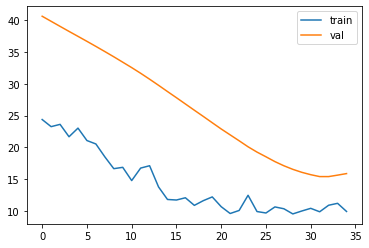

In [16]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label = 'train')
plt.plot(val_losses, label = 'val')
plt.legend()

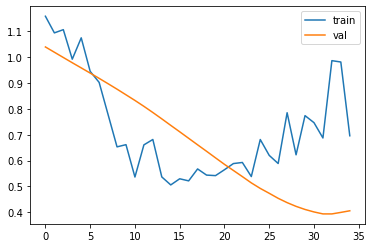

In [17]:

import matplotlib.pyplot as plt
plt.plot(train_errors, label = 'train')
plt.plot(val_errors, label = 'val')
plt.legend()

In [18]:
unlabelled = pd.read_csv('data/la_train_grid_with_weather.csv')

/home/ding/anaconda3/envs/comp579/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [19]:
from pathlib import Path

files = list(Path("data/unlabelled").glob("*.csv"))

In [20]:
data_file = 'merged_unlabelled_data.csv'
# node_cols = 'visibility', 'precipitation_depth']
node_cols = ['wind_x', 'wind_y', 'temperature', 'pressure', 'ceiling', 'dew', 'precipitation_duration' , 'mean_aod','min_aod','max_aod', 'pm25']                                                 
edge_cols = ['wind_x', 'wind_y']
dist_thresh = 30e6
use_self_loops = True
multi_edge_feature = False

# for loop here
# split in k

graph_states_loader, graph =  gather_static_graphs(files[0],
                                                    edge_cols,
                                                    node_cols, 
                                                    dist_thresh,
                                                    multi_edge_feature,
                                                    use_self_loops, 
                                                    pseudo_data = True)


Checkpt doesnt exist, making it


/home/ding/ECSE552_Project/graph.py:51: RuntimeWarning: invalid value encountered in double_scalars
  c = 2 * np.arctan2(a**0.5, (1-a)**0.5)


MemoryError: Unable to allocate 384. GiB for an array with shape (227052, 227052) and data type float64

In [ ]:
for i, (nf, ef, l) in enumerate(graph_states_loader): 
    if i ==1: 
        labels = l
    if i ==1: 
        node_features = nf
        edge_features = ef
    masked_g = MaskedGraphDataset(node_features, edge_features, labels , graph)
    G = masked_g[0]
    with torch.no_grad():
        # DGL
        node_features = G.ndata['feat']
        pred = model(G,node_features)
        
        print(pred)
    
    break
    
    

tensor([[23.0251],
        [23.0281],
        [23.0249],
        [23.0255],
        [23.0248],
        [23.0254],
        [23.0245],
        [23.0257],
        [23.0252],
        [23.0242]])


In [ ]:
for node_feat, edge_feat, label in graph_states_loader:
    masked_g = MaskedGraphDataset(node_feat, edge_feat, label , graph)
    with torch.no_grad():
        pred = model(graph,masked_g)
        print(pred)
        break

AttributeError: 'Graph' object has no attribute 'local_scope'

In [ ]:
'''
1. Integrate pseudolabels into dataloaders of graph
2. Train model
3. Infer pseudolabels 
4. Save results properly
5. Integrate results into code
'''

'\n1. Integrate pseudolabels into dataloaders of graph\n2. Train model\n3. Infer pseudolabels \n4. Save results properly\n5. Integrate results into code\n'